In [1]:
from sklearn.preprocessing import scale
from h2o.automl import H2OAutoML
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators import H2OXGBoostEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators import H2ONaiveBayesEstimator
from sklearn.metrics import confusion_matrix
from google.cloud import bigquery # modulo para interactuar con la API y el service account del DW
import pandas as pd
import numpy as np
import h2o
import datetime
inicio = datetime.datetime.now()


In [2]:
%matplotlib inline
# un bonita funcion para hacer los querys 
def query_BQ(query_string):
    client = bigquery.Client() # inicializamos el cliente, pero antes se debe de fijar la variable de entorno 
    query_job = client.query(query_string)
    results = query_job.result().to_dataframe()  # Waits for job to complete and cast to pandas dataframe
    return(results)

# la consulta
string = '''
SELECT user_id, language, mp_region, country, city, signup_provider, timezone, user_gender, email_domain, os,
adjust_network, baby_gender, weeks_before_birth, baby_age_at_signup_meses, edad_bebe_actual_meses, 
IF( date_diff( premium_conversion_date, signup_date, day) >0, 'Premium', 'Freemium') as did_convert

FROM `celtic-music-240111.dbt_prod_base.ba_predictive_demographics` 
WHERE  os='iOS'
and country not in ('US', 'BR')

'''
raw_data = query_BQ(string) # ejecucion de la consulta 

In [3]:
fin = datetime.datetime.now()
print(fin-inicio)

0:00:28.909988


In [4]:
raw_data['did_convert'].value_counts()

Freemium    162129
Premium       3751
Name: did_convert, dtype: int64

In [5]:
raw_data.describe()

user_id  weeks_before_birth  baby_age_at_signup_meses  \
count  1.658800e+05       165880.000000             165880.000000   
mean   3.471618e+06           38.548204                  4.380715   
std    5.880947e+05            2.396312                  5.505494   
min    2.451441e+06            0.000000                -11.000000   
25%    2.974045e+06           37.000000                  1.000000   
50%    3.551200e+06           39.000000                  3.000000   
75%    4.021949e+06           40.000000                  5.000000   
max    4.332553e+06           44.000000                 46.000000   

       edad_bebe_actual_meses  
count           165880.000000  
mean                11.773372  
std                  6.680829  
min                  0.000000  
25%                  7.000000  
50%                 11.000000  
75%                 14.000000  
max                 48.000000

In [6]:
raw_data.columns

Index(['user_id', 'language', 'mp_region', 'country', 'city',
       'signup_provider', 'timezone', 'user_gender', 'email_domain', 'os',
       'adjust_network', 'baby_gender', 'weeks_before_birth',
       'baby_age_at_signup_meses', 'edad_bebe_actual_meses', 'did_convert'],
      dtype='object')

In [7]:
raw_data.shape

(165880, 16)

In [8]:
# no hizo falta imputar el lenguaje porque desde back el default es ingles
# la variable 'suscribed_to_emails' no puede ser nula por politica de 'backend' 

In [9]:
print(raw_data.shape)
raw_data = raw_data.drop_duplicates()

(165880, 16)


In [10]:
raw_data.shape

(165880, 16)

In [11]:
raw_data = raw_data.dropna()
raw_data.shape

(165880, 16)

In [12]:
raw_data.describe()
# raw_data['user_age'].plot.kde()

user_id  weeks_before_birth  baby_age_at_signup_meses  \
count  1.658800e+05       165880.000000             165880.000000   
mean   3.471618e+06           38.548204                  4.380715   
std    5.880947e+05            2.396312                  5.505494   
min    2.451441e+06            0.000000                -11.000000   
25%    2.974045e+06           37.000000                  1.000000   
50%    3.551200e+06           39.000000                  3.000000   
75%    4.021949e+06           40.000000                  5.000000   
max    4.332553e+06           44.000000                 46.000000   

       edad_bebe_actual_meses  
count           165880.000000  
mean                11.773372  
std                  6.680829  
min                  0.000000  
25%                  7.000000  
50%                 11.000000  
75%                 14.000000  
max                 48.000000

In [13]:
raw_data['did_convert'].value_counts()

Freemium    162129
Premium       3751
Name: did_convert, dtype: int64

In [14]:
numerics = [ 'weeks_before_birth', 'baby_age_at_signup_meses', 'edad_bebe_actual_meses']
categorics = [ i for i in raw_data.columns if i not in numerics]
categorics

['user_id',
 'language',
 'mp_region',
 'country',
 'city',
 'signup_provider',
 'timezone',
 'user_gender',
 'email_domain',
 'os',
 'adjust_network',
 'baby_gender',
 'did_convert']

In [15]:
raw_data[numerics].describe() #hay qe guardar la media y desviacion estandar de las variables numericas 

weeks_before_birth  baby_age_at_signup_meses  edad_bebe_actual_meses
count       165880.000000             165880.000000           165880.000000
mean            38.548204                  4.380715               11.773372
std              2.396312                  5.505494                6.680829
min              0.000000                -11.000000                0.000000
25%             37.000000                  1.000000                7.000000
50%             39.000000                  3.000000               11.000000
75%             40.000000                  5.000000               14.000000
max             44.000000                 46.000000               48.000000

In [16]:
X = scale(raw_data[numerics])
X = pd.DataFrame(X)
X.columns = numerics
X2 = raw_data[categorics]

/root/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


In [17]:
X = pd.concat( [X2.reset_index(drop=True), X  ], axis = 1)

In [18]:
# rebalanceo de la muestra
#aug = X.loc[lambda x: x['did_convert'] == 'Premium']
#X = pd.concat( [X, aug, aug, aug, aug, aug, aug, aug, aug, aug,], axis=0)
#raw_data = pd.concat( [ raw_data.reset_index(drop=True), balance  ], axis = 0)
X.shape

(165880, 16)

In [19]:
h2o.init(min_mem_size = 200)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         4 mins 33 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.26.0.1
H2O cluster version age:    6 months and 21 days !!!
H2O cluster name:           H2O_from_python_unknownUser_4qy3xc
H2O cluster total nodes:    1
H2O cluster free memory:    199.6 Gb
H2O cluster total cores:    70
H2O cluster allowed cores:  70
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.5.6 final
--------------------------  ---------------------------------------------------

In [20]:
X_hf = h2o.H2OFrame(X)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [21]:
X_hf.types
categorics

['user_id',
 'language',
 'mp_region',
 'country',
 'city',
 'signup_provider',
 'timezone',
 'user_gender',
 'email_domain',
 'os',
 'adjust_network',
 'baby_gender',
 'did_convert']

In [22]:
train, test = X_hf.split_frame(ratios = [.7], seed=0)

In [23]:
X_hf.describe()

Rows:165880
Cols:16




user_id language mp_region country city signup_provider timezone user_gender email_domain os adjust_network baby_gender did_convert weeks_before_birth baby_age_at_signup_meses edad_bebe_actual_meses 
 
 
 type int enum enum enum enum enum enum enum enum enum enum enum enum real real real 
 mins 2451441.0 -16.086521822339897 -2.7937113365598267 -1.7622676169374958 
 mean 3471618.0270436467 4.934562524690351e-17 5.263533359669708e-16 -4.386277799724756e-17 
 maxs 4332553.0 2.2750850889753984 7.559614009241797 5.4224916290120815 
 sigma 588094.7460980398 1.0000030142407803 1.000003014240782 1.00000301424078 
 zeros 0 0 0 0 
 missing 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
 0 2534324.0 en Undefined SG Singapore Facebook Asia/Singapore female gmail.com iOS FACEBOOK male Freemium -0.6460796469156714 4.108505560641256 4.225031754687151 
 1 4291649.0 en Kampala District UG Kampala Kinedu Africa/Kampala female gmail.com iOS FACEBOOK male Freemium -7.740336862651127 -0.7957011821068818 -1.4629026483562635 
 2 4040661.0 en Western Australia AU Perth Facebook Australia/Perth female hotmail.com iOS FACEBOOK female Freemium 0.18853884905320573 -1.1589757556437807 -1.4629026483562635 
 3 2478593.0 en South Holland NL Zoetermeer Kinedu Europe/Amsterdam female hotmail.com iOS FACEBOOK female Freemium -0.6460796469156714 5.016691994483503 4.973444176140233 
 4 2925790.0 en National Capital Territory of Delhi AU New Delhi Facebook Australia/Canberra female yahoo.co.in iOS FACEBOOK male Freemium -0.6460796469156714 5.379966568020403 4.973444176140233 
 5 2576654.0 es Departamento de Montevideo UY Montevideo Kinedu America/Montevideo female gmail.com.uy iOS FACEBOOK male Freemium 0.18853884905320573 5.1983292812519535 5.123126660430849 
 6 2966185.0 en Jakarta ID Jakarta Kinedu Asia/Jakarta female yahoo.com.au iOS FACEBOOK male Freemium -0.6460796469156714 3.563593700335907 3.4766193332340705 
 7 4119452.0 en Muharraq BH Al Muharraq Kinedu Asia/Bahrain female hotmail.com iOS FACEBOOK female Freemium -0.6460796469156714 -0.9773384688753312 -1.4629026483562635 
 8 2572992.0 es Leon FR León Kinedu Europe/Paris female gmail.com iOS FACEBOOK male Freemium -0.6460796469156714 3.0186818400305584 3.326936848943454 
 9 3324407.0 es Sinaloa MX Culiacán Facebook America/Mazatlan female hotmail.com iOS FACEBOOK male Freemium 0.6058480970376443 4.835054707715054 4.0753492703965355

In [24]:
gbm = H2OGradientBoostingEstimator(model_id = "gbmRoWx", seed = 0, balance_classes=True, nfolds = 10)
gbm.train(  x= ['language', 'mp_region', 'country', 'city', 'signup_provider', 'timezone', 'user_gender',
               'email_domain',  'adjust_network', 'baby_gender', 'weeks_before_birth', 
               'baby_age_at_signup_meses', 'edad_bebe_actual_meses'], y='did_convert', training_frame=train)
y = gbm.predict(test)
y = y['predict'].as_data_frame()
y_hat = test['did_convert'].as_data_frame()
m = confusion_matrix( y_hat, y).ravel()
output = pd.concat( [y.reset_index(drop=True),  y_hat], axis = 1)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


In [25]:
gbm.model_performance(test)


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.02229499345893073
RMSE: 0.14931508115033368
LogLoss: 0.10790467131004267
Mean Per-Class Error: 0.388529091619894
AUC: 0.645604869583626
pr_auc: 0.04660432036721521
Gini: 0.2912097391672519
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.04463261100805493: 


Freemium    Premium    Error    Rate
--------  ----------  ---------  -------  ----------------
Freemium  45708       2803       0.0578   (2803.0/48511.0)
Premium   939         203        0.8222   (939.0/1142.0)
Total     46647       3006       0.0754   (3742.0/49653.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0446326    0.0978785  127
max f2                       0.0270589    0.16129    208
max f0point5                 0.0593612    0.0893164  86
max accuracy                 0.21263      0.97698    0
max precision                0.0844308    0.126829   39
max recall                   0.000704036  1          398
max specificity              0.21263      0.999979   0
max absolute_mcc             0.0270589    0.0804097  208
max min_per_class_accuracy   0.0186946    0.604378   265
max mean_per_class_accuracy  0.0243426    0.611471   224

Gains/Lift Table: Avg response rate:  2.30 %, avg score:  1.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100095                   0.0712664          3.93673   3.93673            0.0905433        0.0865797   0.0905433                   0.0865797           0.0394046       0.0394046                  293.673   293.673
    2        0.0200189                   0.0614579          3.5868    3.76176            0.082495         0.0657997   0.0865191                   0.0761897           0.0359019       0.0753065                  258.68    276.176
    3        0.0300083                   0.0553925          2.8051    3.4433             0.0645161        0.0583677   0.0791946                   0.070257            0.028021        0.103327                   180.51    244.33
    4        0.0400177                   0.0507425          2.71197   3.26038            0.0623742        0.0529287   0.0749874                   0.0659227           0.0271454       0.130473                   171.197   226.038
    5        0.050007                    0.0472937          2.27914   3.06437            0.0524194        0.049004    0.0704793                   0.0625431           0.0227671       0.15324                    127.914   206.437
    6        0.100034                    0.0367582          2.06543   2.5648             0.047504         0.0413769   0.0589893                   0.0519578           0.103327        0.256567                   106.543   156.48
    7        0.150001                    0.0310075          1.50713   2.21248            0.0346634        0.0336934   0.0508861                   0.0458738           0.0753065       0.331874                   50.7131   121.248
    8        0.200028                    0.0272367          1.57533   2.05313            0.0362319        0.0289726   0.0472211                   0.0416468           0.0788091       0.410683                   57.5326   105.313
    9        0.300042                    0.0223641          1.00686   1.70437            0.0231575        0.0246587   0.0391999                   0.0359841           0.100701        0.511384                   0.686331  70.4372
    10       0.399996                    0.0186137          0.946148  1.5149             0.021761         0.0204211   0.0348422                   0.0320951           0.0945709       0.605954                   -5.38524  51.4901
    11       0.50001                     0.0154248          0.840512  1.38001            0.0193315        0.0170199   0.0317396                   0.0290797           0.084063        0.690018                   -15.9488  38.0007
    12       0.600004                    0.0129411          0.75311   1.27553            0.0173212        0.0141428   0.0293367                   0.0265904           0.0753065       0.765324                   -24.689   27.5531
    13       0.700018                    0.0104335          0.65665   1.18711            0.0151027        0.0116672   0.0273031                   0.0244583           0.0656743       0.830998                   -34.335   18.711
    14       0.799992                    0.00784377         0.53429   1.10553            0.0122885        0.00923274  0.0254267                   0.0225556           0.0534151       0.884413                   -46.571   10.5528
    15       0.899986                    0.0044668          0.560454  1.04497            0.0128902        0.00625599  0.0240338                   0.0207446           0.056042        0.940455                   -43.9546  4.49667
    16       1                           0.000194904        0.595363  1                  0.0136931        0.00235142  0.0229996   

In [26]:
DRF = H2ORandomForestEstimator(model_id = "DRFRoWx", seed = 0, balance_classes=True, binomial_double_trees=True, nfolds = 10)
DRF.train(  x= ['language', 'mp_region', 'country', 'city', 'signup_provider', 'timezone', 'user_gender',
               'email_domain', 'adjust_network', 'baby_gender', 'weeks_before_birth', 
               'baby_age_at_signup_meses', 'edad_bebe_actual_meses'], y='did_convert', training_frame=train)
y = DRF.predict(test)
y = y['predict'].as_data_frame()

drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [27]:
DRF.model_performance(test)


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.02270335448377439
RMSE: 0.15067632356735544
LogLoss: 0.14666416581953548
Mean Per-Class Error: 0.41753101766400247
AUC: 0.6052976465770614
pr_auc: 0.03409527964619564
Gini: 0.21059529315412284
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.010639111636749876: 


Freemium    Premium    Error    Rate
--------  ----------  ---------  -------  ----------------
Freemium  40988       7523       0.1551   (7523.0/48511.0)
Premium   826         316        0.7233   (826.0/1142.0)
Total     41814       7839       0.1681   (8349.0/49653.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0106391    0.0703708  245
max f2                       0.00728779   0.131192   281
max f0point5                 0.0394188    0.0531915  101
max accuracy                 0.230343     0.97698    0
max precision                0.0394188    0.0673469  101
max recall                   4.14385e-06  1          399
max specificity              0.230343     0.999979   0
max absolute_mcc             0.00944964   0.0505626  257
max min_per_class_accuracy   0.00436024   0.571973   320
max mean_per_class_accuracy  0.00387811   0.582469   327

Gains/Lift Table: Avg response rate:  2.30 %, avg score:  0.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100095                   0.0390224          2.88693   2.88693            0.0663984        0.0595502    0.0663984                   0.0595502           0.0288967       0.0288967                  188.693   188.693
    2        0.0200189                   0.0295737          1.48721   2.18707            0.0342052        0.0334797    0.0503018                   0.0465149           0.0148862       0.0437828                  48.7209   118.707
    3        0.0300284                   0.0251515          1.92462   2.09959            0.0442656        0.0272037    0.0482897                   0.0400778           0.0192644       0.0630473                  92.4623   109.959
    4        0.0400177                   0.022253           1.40255   1.92559            0.0322581        0.0235828    0.0442879                   0.0359603           0.0140105       0.0770578                  40.2548   92.5592
    5        0.050007                    0.0200074          1.9285    1.92617            0.0443548        0.0210528    0.0443012                   0.0329824           0.0192644       0.0963222                  92.8503   92.6173
    6        0.100014                    0.0141794          1.57596   1.75107            0.0362465        0.0166806    0.0402739                   0.0248315           0.0788091       0.175131                   57.596    75.1067
    7        0.150001                    0.0109568          1.66418   1.72211            0.0382756        0.0124538    0.0396079                   0.0207067           0.0831874       0.258319                   66.4184   72.2113
    8        0.200008                    0.0089168          1.38334   1.63741            0.0318164        0.00988928   0.0376599                   0.0180021           0.0691769       0.327496                   38.3343   63.7412
    9        0.300002                    0.00631678         1.15594   1.47693            0.0265861        0.00749734   0.0339689                   0.0145007           0.115587        0.443082                   15.5937   47.6931
    10       0.399996                    0.004697           1.05961   1.37261            0.0243706        0.00546733   0.0315694                   0.0122425           0.105954        0.549037                   5.96087   37.2606
    11       0.50001                     0.00354206         1.03313   1.3047             0.0237616        0.00409491   0.0300077                   0.0106128           0.103327        0.652364                   3.31293   30.4702
    12       0.600004                    0.00259898         0.858195  1.23029            0.0197382        0.00305306   0.0282962                   0.00935291          0.0858144       0.738179                   -14.1805  23.0289
    13       0.699998                    0.00176818         0.691811  1.15337            0.0159114        0.00217335   0.026527                    0.00832732          0.0691769       0.807356                   -30.8189  15.3368
    14       0.799992                    0.00102577         0.735596  1.10115            0.0169184        0.00139398   0.025326                    0.00746069          0.0735552       0.880911                   -26.4404  10.1149
    15       0.899986                    0.000377539        0.569211  1.04205            0.0130916        0.000692528  0.0239667                   0.00670871          0.0569177       0.937828                   -43.0789  4.20478
    16       1                           0                  0.621629  1                  0.0142972        0.00

In [28]:
GLM = H2OGeneralizedLinearEstimator(model_id = "GLMRoWx", seed = 0,family = 'binomial', nfolds = 10)
GLM.train(  x= ['language', 'mp_region', 'country', 'city', 'signup_provider', 'timezone', 'user_gender',
               'email_domain', 'adjust_network', 'baby_gender', 'weeks_before_birth', 
               'baby_age_at_signup_meses', 'edad_bebe_actual_meses'], y='did_convert', training_frame=train)
y = GLM.predict(test)
y = y['predict'].as_data_frame()
m = confusion_matrix( test['did_convert'].as_data_frame(), y).ravel()

glm Model Build progress: |███████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [29]:
GLM.model_performance(test)


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.022341709803389002
RMSE: 0.14947143474051824
LogLoss: 0.10687109059590191
Null degrees of freedom: 49652
Residual degrees of freedom: 49641
Null deviance: 10874.097415836955
Residual deviance: 10612.940522716633
AIC: 10636.940522716633
AUC: 0.6465894441548111
pr_auc: 0.041771021609682414
Gini: 0.29317888830962224
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.03582351655142954: 


Freemium    Premium    Error    Rate
--------  ----------  ---------  -------  ----------------
Freemium  47173       1338       0.0276   (1338.0/48511.0)
Premium   1029        113        0.9011   (1029.0/1142.0)
Total     48202       1451       0.0477   (2367.0/49653.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0358235    0.0871577  106
max f2                       0.0259217    0.149236   167
max f0point5                 0.0361905    0.0816897  104
max accuracy                 0.0776708    0.976759   0
max precision                0.0709756    0.121951   4
max recall                   0.00480442   1          396
max specificity              0.0776708    0.999732   0
max absolute_mcc             0.0259217    0.0686339  167
max min_per_class_accuracy   0.0227221    0.601657   202
max mean_per_class_accuracy  0.022858     0.604137   201

Gains/Lift Table: Avg response rate:  2.30 %, avg score:  2.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100296                   0.0533713          2.79383   2.79383            0.064257         0.0621981  0.064257                    0.0621981           0.028021        0.028021                   179.383   179.383
    2        0.0200592                   0.0412181          3.40498   3.09941            0.0783133        0.0464573  0.0712851                   0.0543277           0.0341506       0.0621716                  240.498   209.941
    3        0.0383663                   0.0356329          2.7264    2.92142            0.0627063        0.0370135  0.0671916                   0.046066            0.0499124       0.112084                   172.64    192.142
    4        0.0586067                   0.0344597          1.60072   2.4653             0.0368159        0.0344885  0.056701                    0.0420676           0.0323993       0.144483                   60.0719   146.53
    5        0.108493                    0.0313498          1.80797   2.16305            0.0415826        0.0325348  0.0497494                   0.0376843           0.0901926       0.234676                   80.7967   116.305
    6        0.153445                    0.0291317          1.67527   2.02015            0.0385305        0.0301141  0.0464628                   0.0354666           0.0753065       0.309982                   67.5266   102.015
    7        0.203512                    0.0271216          1.39916   1.86738            0.0321802        0.0277522  0.042949                    0.0335687           0.0700525       0.380035                   39.9163   86.738
    8        0.30117                     0.0247577          1.09392   1.61658            0.0251598        0.0257759  0.0371807                   0.0310418           0.10683         0.486865                   9.39237   61.6579
    9        0.403037                    0.0227216          1.14328   1.49695            0.026295         0.0237656  0.0344293                   0.0292028           0.116462        0.603327                   14.3279   49.6953
    10       0.5072                      0.020841           0.94154   1.38289            0.0216551        0.0216472  0.0318059                   0.0276511           0.0980736       0.701401                   -5.84597  38.2889
    11       0.605442                    0.0195663          1.0072    1.32193            0.0231652        0.0200988  0.0304038                   0.0264256           0.0989492       0.80035                    0.720074  32.1928
    12       0.70171                     0.0183916          0.627626  1.22668            0.0144351        0.0188185  0.0282131                   0.025382            0.0604203       0.860771                   -37.2374  22.6676
    13       0.804966                    0.0169214          0.534265  1.13786            0.0122879        0.0175521  0.0261703                   0.0243776           0.0551664       0.915937                   -46.5735  13.7857
    14       0.903027                    0.0149872          0.455418  1.06375            0.0104744        0.0160183  0.0244659                   0.0234699           0.0446585       0.960595                   -54.4582  6.37505
    15       1                           0.00375443         0.406346  1                  0.00934579       0.0121013  0.0229996                   0.0223674           0.0394046       1                          -59.3654  0

In [30]:
XGB = H2OXGBoostEstimator(model_id = "XGBRoWx", seed = 0, nfolds = 10)
XGB.train(  x= ['language', 'mp_region', 'country', 'city', 'signup_provider', 'timezone', 'user_gender',
               'email_domain', 'adjust_network', 'baby_gender', 'weeks_before_birth', 
               'baby_age_at_signup_meses', 'edad_bebe_actual_meses'], y='did_convert', training_frame=train)
y = XGB.predict(test)
y = y['predict'].as_data_frame()
m = confusion_matrix( test['did_convert'].as_data_frame(), y).ravel()

xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%


In [31]:
XGB.model_performance(test)


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.0222478777948276
RMSE: 0.14915722508422982
LogLoss: 0.10477633737453415
Mean Per-Class Error: 0.3712333592095909
AUC: 0.6780611189669695
pr_auc: 0.052346382454358624
Gini: 0.35612223793393905
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.055000140772838345: 


Freemium    Premium    Error    Rate
--------  ----------  ---------  -------  ----------------
Freemium  46592       1919       0.0396   (1919.0/48511.0)
Premium   967         175        0.8468   (967.0/1142.0)
Total     47559       2094       0.0581   (2886.0/49653.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0550001    0.108158   175
max f2                       0.0289894    0.167871   256
max f0point5                 0.093183     0.0984144  117
max accuracy                 0.539276     0.977021   0
max precision                0.539276     1          0
max recall                   0.00223553   1          397
max specificity              0.539276     1          0
max absolute_mcc             0.0440598    0.0869987  202
max min_per_class_accuracy   0.0206564    0.62289    297
max mean_per_class_accuracy  0.0235167    0.628767   281

Gains/Lift Table: Avg response rate:  2.30 %, avg score:  2.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100095                   0.101558           5.16149   5.16149            0.118712         0.159305    0.118712                    0.159305            0.0516637       0.0516637                  416.149   416.149
    2        0.0200189                   0.0761388          3.23687   4.19918            0.0744467        0.0870052   0.0965795                   0.123155            0.0323993       0.084063                   223.687   319.918
    3        0.0300083                   0.0640951          3.24339   3.88101            0.0745968        0.0696144   0.0892617                   0.105332            0.0323993       0.116462                   224.339   288.101
    4        0.0400177                   0.0562069          2.88693   3.63237            0.0663984        0.0598054   0.083543                    0.0939448           0.0288967       0.145359                   188.693   263.237
    5        0.0500473                   0.0506475          2.09537   3.32435            0.0481928        0.053175    0.0764588                   0.0857744           0.0210158       0.166375                   109.537   232.435
    6        0.100054                    0.0379774          1.83862   2.58178            0.0422876        0.043145    0.05938                     0.0644683           0.091944        0.258319                   83.862    158.178
    7        0.150041                    0.0316767          1.64667   2.27024            0.0378727        0.0346      0.0522148                   0.0545175           0.0823117       0.34063                    64.6666   127.024
    8        0.200089                    0.0276123          1.60968   2.10502            0.0370221        0.0295476   0.0484147                   0.0482719           0.0805604       0.421191                   60.9685   110.502
    9        0.300002                    0.0235553          1.2971    1.83595            0.0298327        0.0252295   0.0422261                   0.0405978           0.129597        0.550788                   29.7095   83.5948
    10       0.400157                    0.0201453          0.952988  1.61495            0.0219184        0.0217951   0.0371433                   0.0358917           0.0954466       0.646235                   -4.7012   61.4952
    11       0.50001                     0.0176932          0.850638  1.46232            0.0195643        0.0187794   0.0336327                   0.0324743           0.0849387       0.731173                   -14.9362  46.2317
    12       0.601031                    0.015946           0.797461  1.35057            0.0183413        0.0168176   0.0310626                   0.0298427           0.0805604       0.811734                   -20.2539  35.0569
    13       0.699998                    0.0139176          0.654751  1.25219            0.015059         0.0149437   0.0288                      0.0277363           0.0647986       0.876532                   -34.5249  25.2193
    14       0.799992                    0.0120742          0.577968  1.16792            0.0132931        0.0130373   0.0268617                   0.025899            0.0577933       0.934326                   -42.2032  16.7919
    15       0.900006                    0.00903585         0.420256  1.08483            0.00966573       0.0106741   0.0249508                   0.0242071           0.0420315       0.976357                   -57.9744  8.48341
    16       1                           0.00105912         0.236442  1                  0.00543807       0.00606701  0.0229996

In [32]:
n1 = list(np.arange(50, 500, 150 ))
n2 =  list(np.arange(20, 242, 100))
params = { 'ntrees': n1, 'max_depth' : n2 }
DRF = H2ORandomForestEstimator(model_id = "RoWiOSGrid", seed = 0, balance_classes=True, binomial_double_trees=True, nfolds = 10)
#GGB = H2OGradientBoostingEstimator(model_id = "gbmRoWiOS", seed = 0, balance_classes=True, nfolds = 10)
grid = H2OGridSearch(model = DRF, hyper_params=params)
params 

{'max_depth': [20, 120, 220], 'ntrees': [50, 200, 350]}

In [33]:
grid.train(x=['language', 'mp_region', 'country',
 'city',
 'signup_provider',
 'timezone',
 'user_gender',
 'email_domain',
 'adjust_network',
 'baby_gender',
 'weeks_before_birth',
 'baby_age_at_signup_meses',
 'edad_bebe_actual_meses'], y = 'did_convert', training_frame = train, validation_frame = test)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [34]:
grid.accuracy()

{'Grid_DRF_py_3_sid_9074_model_python_1581022651388_2883_model_1': [[0.031190731508208714,
   0.9832599157715005]],
 'Grid_DRF_py_3_sid_9074_model_python_1581022651388_2883_model_2': [[0.08063153347030412,
   0.9988866347766009]],
 'Grid_DRF_py_3_sid_9074_model_python_1581022651388_2883_model_3': [[0.08063153347030412,
   0.9988866347766009]],
 'Grid_DRF_py_3_sid_9074_model_python_1581022651388_2883_model_4': [[0.031464733604253586,
   0.9855570566672094]],
 'Grid_DRF_py_3_sid_9074_model_python_1581022651388_2883_model_5': [[0.1026866116186821,
   0.999031856327479]],
 'Grid_DRF_py_3_sid_9074_model_python_1581022651388_2883_model_6': [[0.1026866116186821,
   0.999031856327479]],
 'Grid_DRF_py_3_sid_9074_model_python_1581022651388_2883_model_7': [[0.03142522667920301,
   0.9860411285034699]],
 'Grid_DRF_py_3_sid_9074_model_python_1581022651388_2883_model_8': [[0.10325435523474007,
   0.9990670615519343]],
 'Grid_DRF_py_3_sid_9074_model_python_1581022651388_2883_model_9': [[0.10325435523

In [35]:
grid_train = grid.get_grid(sort_by='recall', decreasing=True )
grid_train # el modelo con mayor acuracy  tiene 10 de max depth, 145 trees y .8156 pero tiende a confundir más los negativos error final de .28

    max_depth ntrees  \
0         120     50   
1         220     50   
2         220    200   
3         120    200   
4         120    350   
5         220    350   
6          20    200   
7          20    350   
8          20     50   

                                                        model_ids  \
0  Grid_DRF_py_3_sid_9074_model_python_1581022651388_2883_model_2   
1  Grid_DRF_py_3_sid_9074_model_python_1581022651388_2883_model_3   
2  Grid_DRF_py_3_sid_9074_model_python_1581022651388_2883_model_6   
3  Grid_DRF_py_3_sid_9074_model_python_1581022651388_2883_model_5   
4  Grid_DRF_py_3_sid_9074_model_python_1581022651388_2883_model_8   
5  Grid_DRF_py_3_sid_9074_model_python_1581022651388_2883_model_9   
6  Grid_DRF_py_3_sid_9074_model_python_1581022651388_2883_model_4   
7  Grid_DRF_py_3_sid_9074_model_python_1581022651388_2883_model_7   
8  Grid_DRF_py_3_sid_9074_model_python_1581022651388_2883_model_1   

                recall  
0  0.26638558834802606  
1  0.2663855883480

In [36]:
path = '/home/antonio/fbfakeevents/Conversion/Demographics/Predictive/Model/RoW/iOS/'

g = grid_train
print(g.grid_id)
print(g)
for i, m in enumerate(g.models):
    print("Save model" + m.model_id + " to " + path + "/" + m.model_id)
    h2o.save_model(model=m, path=path, force=True)

Grid_DRF_py_3_sid_9074_model_python_1581022651388_2883
    max_depth ntrees  \
0         120     50   
1         220     50   
2         220    200   
3         120    200   
4         120    350   
5         220    350   
6          20    200   
7          20    350   
8          20     50   

                                                        model_ids  \
0  Grid_DRF_py_3_sid_9074_model_python_1581022651388_2883_model_2   
1  Grid_DRF_py_3_sid_9074_model_python_1581022651388_2883_model_3   
2  Grid_DRF_py_3_sid_9074_model_python_1581022651388_2883_model_6   
3  Grid_DRF_py_3_sid_9074_model_python_1581022651388_2883_model_5   
4  Grid_DRF_py_3_sid_9074_model_python_1581022651388_2883_model_8   
5  Grid_DRF_py_3_sid_9074_model_python_1581022651388_2883_model_9   
6  Grid_DRF_py_3_sid_9074_model_python_1581022651388_2883_model_4   
7  Grid_DRF_py_3_sid_9074_model_python_1581022651388_2883_model_7   
8  Grid_DRF_py_3_sid_9074_model_python_1581022651388_2883_model_1   

             

In [81]:
#model = grid_train.models[0]
path = '/home/antonio/fbfakeevents/Conversion/Demographics/Predictive/Model/RoW/iOS/'
model =  h2o.load_model(path+ '/'+ 'Grid_DRF_py_3_sid_9074_model_python_1581022651388_2883_model_9')
#model

In [82]:
model.model_performance(test)


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.02303706185509765
RMSE: 0.1517796490149376
LogLoss: 0.17275399589082663
Mean Per-Class Error: 0.4173015754167876
AUC: 0.6084704243690591
pr_auc: 0.03386108514781665
Gini: 0.21694084873811814
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0024261514049616173: 


Freemium    Premium    Error    Rate
--------  ----------  ---------  -------  ----------------
Freemium  41994       6517       0.1343   (6517.0/48511.0)
Premium   871         271        0.7627   (871.0/1142.0)
Total     42865       6788       0.1488   (7388.0/49653.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.00242615   0.068348   309
max f2                       0.00124203   0.136586   342
max f0point5                 0.00632217   0.0516648  246
max accuracy                 0.592678     0.97698    0
max precision                0.470334     0.111111   7
max recall                   3.04031e-06  1          399
max specificity              0.592678     0.999979   0
max absolute_mcc             0.00124203   0.0552799  342
max min_per_class_accuracy   0.000724866  0.58056    363
max mean_per_class_accuracy  0.000724866  0.582698   363

Gains/Lift Table: Avg response rate:  2.30 %, avg score:  0.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100095                   0.015269           1.83714   1.83714            0.0422535        0.0734975    0.0422535                   0.0734975           0.0183888       0.0183888                  83.714    83.714
    2        0.0200189                   0.00984426         1.83714   1.83714            0.0422535        0.011954     0.0422535                   0.0427257           0.0183888       0.0367776                  83.714    83.714
    3        0.0300083                   0.00737347         2.62978   2.101              0.0604839        0.00848134   0.0483221                   0.0313263           0.0262697       0.0630473                  162.978   110.1
    4        0.0400177                   0.00606752         1.57469   1.96936            0.0362173        0.00666409   0.0452944                   0.0251576           0.0157618       0.0788091                  57.4692   96.9355
    5        0.050007                    0.00521706         1.66553   1.90866            0.0383065        0.00559027   0.0438985                   0.0212489           0.0166375       0.0954466                  66.5526   90.8663
    6        0.100014                    0.00312622         1.62849   1.76858            0.0374547        0.00397703   0.0406766                   0.012613            0.0814361       0.176883                   62.8492   76.8577
    7        0.150001                    0.00220046         1.50652   1.68125            0.0346495        0.00261342   0.0386681                   0.00928067          0.0753065       0.252189                   50.6524   68.125
    8        0.200008                    0.001692           1.36583   1.60239            0.0314136        0.00193014   0.0368543                   0.00744285          0.0683012       0.32049                    36.5832   60.2387
    9        0.300002                    0.00108997         1.33108   1.51196            0.0306143        0.00135494   0.0347744                   0.00541369          0.1331          0.45359                    33.1079   51.1957
    10       0.399996                    0.000761267        1.05085   1.39669            0.0241692        0.00091233   0.0321233                   0.0042884           0.105079        0.558669                   5.08516   39.6687
    11       0.50001                     0.000533297        0.875533  1.29244            0.0201369        0.00064139   0.0297257                   0.00355891          0.0875657       0.646235                   -12.4467  29.2443
    12       0.600004                    0.000375653        0.901981  1.22737            0.0207452        0.00045064   0.0282291                   0.0030409           0.0901926       0.736427                   -9.80191  22.7371
    13       0.699998                    0.000254876        0.761867  1.16087            0.0175227        0.000311491  0.0266997                   0.00265101          0.0761821       0.812609                   -23.8133  16.0874
    14       0.799992                    0.00015487         0.674296  1.10005            0.0155086        0.000202604  0.0253008                   0.00234497          0.0674256       0.880035                   -32.5704  10.0055
    15       0.899986                    6.58977e-05        0.630511  1.04789            0.0145015        0.000109545  0.024101                    0.0020966           0.0630473       0.943082                   -36.9489  4.78856
    16       1                           0                  0.569097  1                  0.013089         2.56935e-

In [83]:
#model.varimp_plot(num_of_features=15)

In [84]:
roc = model.model_performance(test_data=test, train=train)

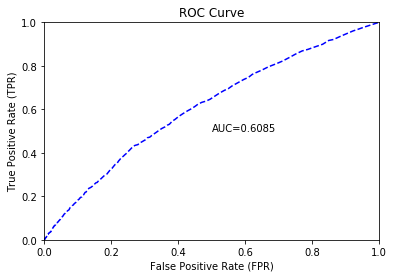

In [85]:
roc.plot()

In [ ]:
X_hf.col_names

In [ ]:
modelo = H2ORandomForestEstimator(nfolds = 10,  balance_classes=True, seed=0, binomial_double_trees=True, max_depth=70, ntrees=50)
modelo.train(training_frame=X_hf, x = ['language',
 'mp_region',
 'country',
 'city',
 'signup_provider',
 'timezone',
 'user_gender',
 'email_domain',
 'os',
 'adjust_network',
 'baby_gender',
 'weeks_before_birth',
 'baby_age_at_signup_meses',
 'edad_bebe_actual_meses'], y ='did_convert')   

In [ ]:
X_hf.head()

In [ ]:
xx = modelo.model_performance(test)
modelo.confusion_matrix()

In [ ]:
xx.plot()
numerics + categorics

In [ ]:
modelo.varimp_plot(num_of_features=len(X_hf.col_names))

In [ ]:
y_hat = modelo.predict(X_hf)


In [ ]:
X_hf

In [ ]:
y = y_hat['predict']
y['real'] = X_hf['did_convert']

In [ ]:
y.table()

In [ ]:
model_path = h2o.save_model(model=modelo, path="/home/antonio/Predictive/Model", force=True)

In [ ]:
model_path

In [ ]:
#model = h2o.load_model('/home/antonio/Predictive/Model/Grid_DRF_py_4_sid_8bfd_model_python_1563329918579_1_model_5')
#print(model.recall)
print(modelo.nfolds)
print(modelo.ntrees)
print(modelo.max_depth)
print(modelo.balance_classes)
print(modelo.binomial_double_trees)
a = modelo.summary()
a.as_data_frame()

In [ ]:
query = "INSERT INTO `celtic-music-240111.FBPredictive.FBModels` (model_id, date_created, type_model, n_rows) VALUES ('" 
query = query + model_path + "' , current_timestamp(), 'Demographics', " + str(X_hf.shape[0]) + ')'
query 